## CrossOver Strategy

Usually we apply crossover strategy on short term and long term moving average. The basic premise is when the short-term average crosses the long-term average, buy signal is triggered.<br>
Here I am implementing the same but with some modification. Instead of moving average, I'll use <b>slope.</b>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm

In [2]:
file = pd.read_csv('BANKNIFTY20JUNFUT.txt', sep=",", header=None)

In [9]:
data=file.drop([0,1,4], axis=1)
data.columns=['Time','Price']
data

,Time,Price
0,09:15:00,19995.4
1,09:15:01,20000.0
2,09:15:02,20000.0
3,09:15:03,20005.0
4,09:15:04,20004.8
...,...,...
22496,15:29:56,20140.0
22497,15:29:57,20140.0
22498,15:29:58,20140.0
22499,15:29:59,20140.0


In [15]:
def slope(ser,n):
    slopes = [i*0 for i in range(n-1)]
    for i in range(n,len(ser)+1):
        y = ser[i-n:i]
        x = np.array(range(n))
        y_scaled = (y - y.min())/(y.max() - y.min())
        x_scaled = (x - x.min())/(x.max() - x.min()) 
        x_scaled = sm.add_constant(x_scaled)
        model = sm.OLS(y_scaled,x_scaled)
        results = model.fit()
        slopes.append(results.params[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)

In [16]:
def Dual_Moving_Crossover(DF, short_window, long_window):
    df=DF.copy()
    df['short_mavg'] = slope(df['Price'],short_window)
    df['long_mavg'] = slope(df['Price'],long_window)
    df.dropna(inplace=True)
    return df

In [30]:
short_window=20
long_window=60
DMC_signals = pd.DataFrame()
DMC_signals=(Dual_Moving_Crossover(data,short_window,long_window))
DMC_signals['signal']= 0.0
DMC_signals['signal'][short_window:] = np.where(DMC_signals['short_mavg'][short_window:]>DMC_signals['long_mavg'][short_window:], 1.0, 0.0)   
DMC_signals['positions'] = DMC_signals['signal'].diff()
DMC_signals.dropna(inplace=True)
print(DMC_signals)

           Time    Price  short_mavg  long_mavg  signal  positions
1      09:15:01  20000.0    0.000000   0.000000     0.0        0.0
2      09:15:02  20000.0    0.000000   0.000000     0.0        0.0
3      09:15:03  20005.0    0.000000   0.000000     0.0        0.0
4      09:15:04  20004.8    0.000000   0.000000     0.0        0.0
5      09:15:05  20017.0    0.000000   0.000000     0.0        0.0
...         ...      ...         ...        ...     ...        ...
22394  15:28:14  20140.0   26.139508   5.445017     1.0        0.0
22395  15:28:15  20140.0   24.960453   6.471175     1.0        0.0
22396  15:28:16  20140.0   16.942040   4.213047     1.0        0.0
22397  15:28:17  20140.0    7.036580   5.330998     1.0        0.0
22398  15:28:18  20140.0  -15.185837   6.431548     0.0       -1.0

[22398 rows x 6 columns]


C:\Users\chashah4\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


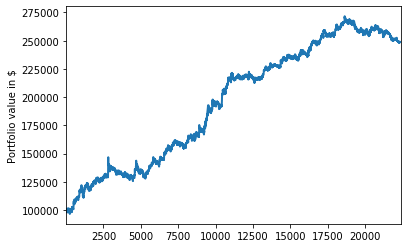

In [31]:
initial_capital= float(100000.0)
positions = pd.DataFrame(index=DMC_signals.index).fillna(0.0)
# Buy a 120 shares
positions['Share'] = 100*DMC_signals['signal']
portfolio = positions.multiply(DMC_signals['Price'], axis=0)
pos_diff = positions.diff()
portfolio['holdings'] = (positions.multiply(DMC_signals['Price'], axis=0)).sum(axis=1)
portfolio['cash'] = initial_capital - (pos_diff.multiply(DMC_signals['Price'], axis=0)).sum(axis=1).cumsum()   
portfolio['total'] = portfolio['cash'] + portfolio['holdings']
portfolio['returns'] = portfolio['total'].pct_change()
portfolio.dropna(inplace=True)
portfolio.describe()
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')
portfolio['total'].plot(ax=ax1, lw=2.)
plt.show()

I tried various time durations like (5,30),(5,20),(20,60) and (10,60). <b>(20,60)</b> produced the best result. Although the other durations produce highly negative results as well where the portfolio value went down to almost the negative of the initial capital. Because of this we cannot generalise this\ strategy.